In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [161]:
tracks = pd.read_csv('../augmented_ds.csv')
artists = pd.read_csv('../artists.csv')
artists['followers_log'] = np.log10(artists.followers + 1)

# Removing Outliers

In [162]:
p5, p95 = artists.followers_log.quantile([0.05, 0.95])
print(f'5% percentile: {p5}, 95% percentile: {p95}')


## Quetion 1: should we include the most / least popular artists?
data_mat = artists.loc[(artists.followers_log > p5) & (artists.followers_log < p95)][['followers_log', 'popularity']].values
# data_mat = artists[['followers_log', 'popularity']].values

# define a new dataframe without the outlier points
artists_no_quantiles = artists.loc[(artists.followers_log > p5) & (artists.followers_log < p95)]

# show that after the outlier removal still a linear relationship
np.corrcoef(data_mat, rowvar=False)

5% percentile: 0.6020599913279624, 95% percentile: 5.295801885158937


array([[1.        , 0.85256029],
       [0.85256029, 1.        ]])

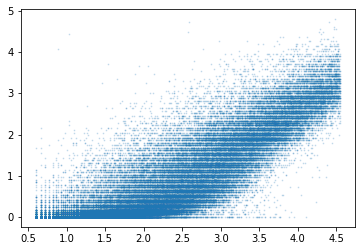

In [163]:
plt.scatter(data_mat[:,0] / np.std(data_mat[:,0]), data_mat[:, 1] / np.std(data_mat[:,1]), alpha= 0.2, s=0.6)

Popularity and followers are highly correlated! Maybe consider doing a PCA-like transformation to get a singular and corrected value. Notice as well, that there are some artist that are highly unpopular while still having a significant amount of followers. Are these dead people? Lets find out :)

In [164]:
artists.loc[(artists.followers_log > 3.0) & (artists.popularity < 0.05)].sort_values('followers').head()

,Unnamed: 0,genres,name,followers,popularity,followers_log
33895,02VOvsHPy9CloBluRlwjmI,[],Block Scholars,1000.0,0.0,3.000434
32954,63Ng0OE35kBFYyrAC7q0aP,[],Julio D,1001.0,0.0,3.000868
40277,0qSwFYKvwGYZfZ78QqDt0f,[],Lil Key,1015.0,0.0,3.006894
77488,5Tqd93YVt2DVkjFo4sQ9BM,[],Bass Man DJ Fury,1017.0,0.0,3.007748
67816,1ehOZ9iiBmiX3AmXnopM0O,[],Er305,1031.0,0.0,3.013680


Include probably famous people from platform like youtube or insta, but who are shitty musicians. For instance, minecraft troll song (Lachlan - Mobs cant handle me).

To filter these "indie artists", simply thresholding 'followers' or 'popularity' is not sufficient. Instead we need a PCA to remove the outsider of the distribution.

In [165]:
X = (data_mat - np.mean(data_mat, axis=0, keepdims=True)) / np.std(data_mat, axis=0, keepdims=True)

In [166]:
V, Sigma, _ = np.linalg.svd(np.cov(X, rowvar=False), hermitian=True)

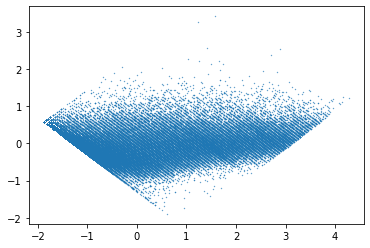

In [167]:
tmp = X @ V
plt.scatter(tmp[:, 0], tmp[:, 1], s=0.1)

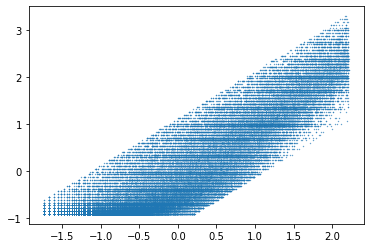

In [168]:
tmp2 = tmp[np.fabs(tmp[:,1]) < 0.8]  @ V.T
plt.scatter(tmp2[:, 0], tmp2[:, 1], s=0.1) 

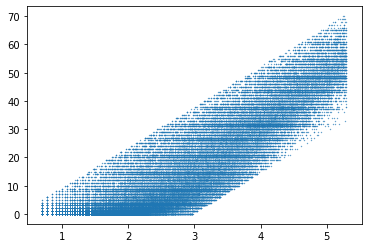

In [169]:
artist_data = artists_no_quantiles.iloc[np.where(np.fabs(tmp[:, 1]) < 0.8)][['followers_log', 'popularity']].values

plt.scatter(artist_data[:, 0], artist_data[:, 1], s=0.1)

filtered_artists = artists_no_quantiles.iloc[np.where(np.fabs(tmp[:, 1]) < 0.8)]

In [170]:
print(artist_data.shape)

(73328, 2)


In [171]:
filtered_artists.sort_values(by='popularity')

,Unnamed: 0,genres,name,followers,popularity,followers_log
42358,43Iu1CpxeQoxMt7Ka5wg6a,"['kentucky mountain folk', 'traditional folk']",Shortbuckle Roark & Family,13.0,0.0,1.146128
15574,3j7GagQE0E8Nko9H81G0Lx,[],M.G. Lederman,14.0,0.0,1.176091
15571,3GXAZTYaFeNM2v7oXZLtaH,['boston rock'],Big Big Bucks,28.0,0.0,1.462398
45145,1nGNpEpKIEsxKbGyE51OR0,[],Matthias Haus,7.0,0.0,0.903090
45150,0lni2MPTJV0tTgLdPhQsNc,[],Loftän,92.0,0.0,1.968483
...,...,...,...,...,...,...
2841,2x7EATekOPhFGRx3syMGEC,"['alternative dance', 'edm', 'indie poptimism'...",The Knocks,179112.0,69.0,5.253127
40541,3IJ21966TwNZI24MwZHMu4,"['escape room', 'trap queen']",Baby Tate,149314.0,69.0,5.174103
71974,5RJFJWYgtgWktosLrUDzff,"['dance pop', 'pop', 'uk pop']",Griff,156906.0,69.0,5.195642
80642,2KbikmQKGiUPR2ARs1h0sq,"['danish hip hop', 'danish pop']",Gilli,182348.0,70.0,5.260903


We still have some artists without a genre - we might want to remove those as we cannot work with them for our genre analysis. However, who are those artists?

(array([2.6708e+04, 4.2240e+03, 2.9860e+03, 1.7680e+03, 1.3540e+03,
        6.8300e+02, 3.4200e+02, 1.3300e+02, 4.3000e+01, 1.3000e+01]),
 array([ 0. ,  6.5, 13. , 19.5, 26. , 32.5, 39. , 45.5, 52. , 58.5, 65. ]),
 <BarContainer object of 10 artists>)

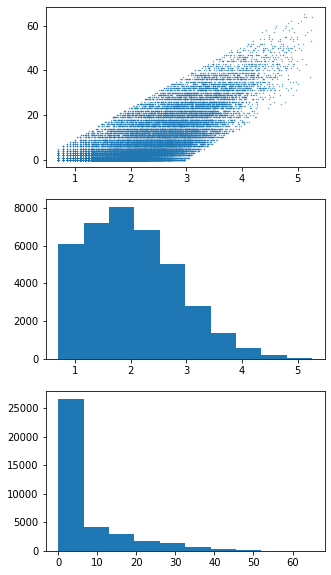

In [172]:
artists_no_genre = filtered_artists[filtered_artists['genres'] == '[]']
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 10))

ax1.scatter(artists_no_genre['followers_log'], artists_no_genre['popularity'], s=0.1)
ax2.hist(artists_no_genre['followers_log'])
ax3.hist(artists_no_genre['popularity'])

In [173]:
artists_no_genre.sort_values(by='popularity')

,Unnamed: 0,genres,name,followers,popularity,followers_log
6,3jfxxO6JNrzzhov82l1wX2,[],Death & Desire,65.0,0.0,1.819544
45838,2Gq0C4Hk5jBfkdMbevsVRL,[],2PRAISE,14.0,0.0,1.176091
45831,5hNZ6kNLBrK9VWdarZJ46I,[],Post Provost,65.0,0.0,1.819544
45827,5Mdm6q20J928SRgRfdvGMX,[],"Siegfried Lorenz, Norman Shetler",25.0,0.0,1.414973
45820,1nvks16rEHZkV3UcjEOGoC,[],Chevere de Chicago,28.0,0.0,1.462398
...,...,...,...,...,...,...
3464,2hmePXeTr2b7cdRAtRjvPq,[],Jeris Johnson,115548.0,62.0,5.062766
68833,2vhrwzjf9H3icunkVFi9tq,[],Smash Into Pieces,143741.0,64.0,5.157584
68560,2PaZWGu5T5nHjY2xxAkFsT,[],THE SCOTTS,181486.0,64.0,5.258846
81005,2WxjxdeF7GGdcCK276qViY,[],Natalie Taylor,129472.0,64.0,5.112179


A large proportion of the artists without genre are unpopular, but have a few followers. However, the overall distribution of those artists is quite similar to the distribution of all artists. So, with filtering out these, we won't manipulate the distribution too much. We only take out some density in the lower-popularity end.

In [174]:
filtered_artists_with_genres = filtered_artists.query('`genres` != "[]"')

(array([5703., 2275., 2565., 1823., 2042., 1639., 2106., 1690., 2636.,
        2229., 2235., 1561., 1931., 1576., 1522.,  658.,  513.,  220.,
         125.,   25.]),
 array([ 0. ,  3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5, 35. ,
        38.5, 42. , 45.5, 49. , 52.5, 56. , 59.5, 63. , 66.5, 70. ]),
 <BarContainer object of 20 artists>)

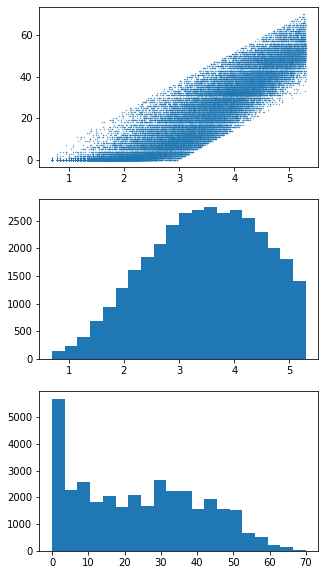

In [175]:
filtered_artists_with_genres
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 10))

ax1.scatter(filtered_artists_with_genres['followers_log'], filtered_artists_with_genres['popularity'], s=0.1)
ax2.hist(filtered_artists_with_genres['followers_log'], bins=20)
ax3.hist(filtered_artists_with_genres['popularity'], bins=20)

The dataset now seems a lot cleaner. The overall shape of the distribution of log_followers vs. popularity is still the same. log_followers has shifted more towards the center. It could be a Gaussian. Popularity seems to be equally distributed in the field 10 < x < 50. Very large density at 0, very low density above 50. The question is, where should we classify the songs into popular / unpopular? 

In [176]:
first_genre_as_string = filtered_artists_with_genres['genres'].apply(
    lambda list_string: str(eval(list_string)[0])
)

# take only the first genre for the dataset
filtered_artists_with_genres.loc[:, ['genres']] = first_genre_as_string

/usr/local/Caskroom/miniconda/base/envs/datlit/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [184]:
filtered_artists_with_genres.rename(columns={
    'Unnamed: 0':'artist_id',
    'name': 'artist_name',
    'followers': 'artist_followers',
    'popularity': 'artist_popularity',
    'followers_log': 'artist_followers_log',
}, inplace=True)

In [185]:
filtered_artists_with_genres.to_csv("filtered_artists_with_genre.csv", index=False)